# Heart Rate Time Series Analysis and Prediction

In this notebook, we will analyze heart rate data and build models to predict the median of the next five consecutive heart rate values. We will compare an ARIMA model with a simple rolling median model and evaluate their performances using appropriate error metrics.

## Table of Contents

1. [Data Preparation](#data-preparation)
2. [Exploratory Data Analysis](#eda)
3. [Stationarity Check](#stationarity-check)
4. [Train-Test Split](#train-test-split)
5. [Model Training and Validation](#model-training)
    - [ARIMA Model](#arima-model)
    - [Rolling Median Model](#rolling-median-model)
6. [Model Evaluation](#model-evaluation)
7. [Residual Analysis](#residual-analysis)
8. [Conclusion](#conclusion)

In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Preparation <a id='data-preparation'></a>

First, we load the heart rate data from a JSON file and combine heart rate samples from all laps into a single DataFrame.

In [2]:
# Load data from JSON file
with open('./data/training_summary.json') as file:
    data = json.load(file)

# Extract heart rate samples from each lap
hr_samples = []
for lap in data['laps']:
    hr_samples.extend(lap['heartRateSamples'])

# Create a DataFrame
df = pd.DataFrame(hr_samples)

# Check for missing values
if df['heart_rate'].isnull().sum() > 0:
    df['heart_rate'] = df['heart_rate'].interpolate()

# Display the first few rows
df.head()

,sample_index,heart_rate
0,0,120.0
1,1,121.2
2,2,122.4
3,3,123.6
4,4,124.8


## Exploratory Data Analysis <a id='eda'></a>

Let's visualize the heart rate samples to get an initial understanding of the data.

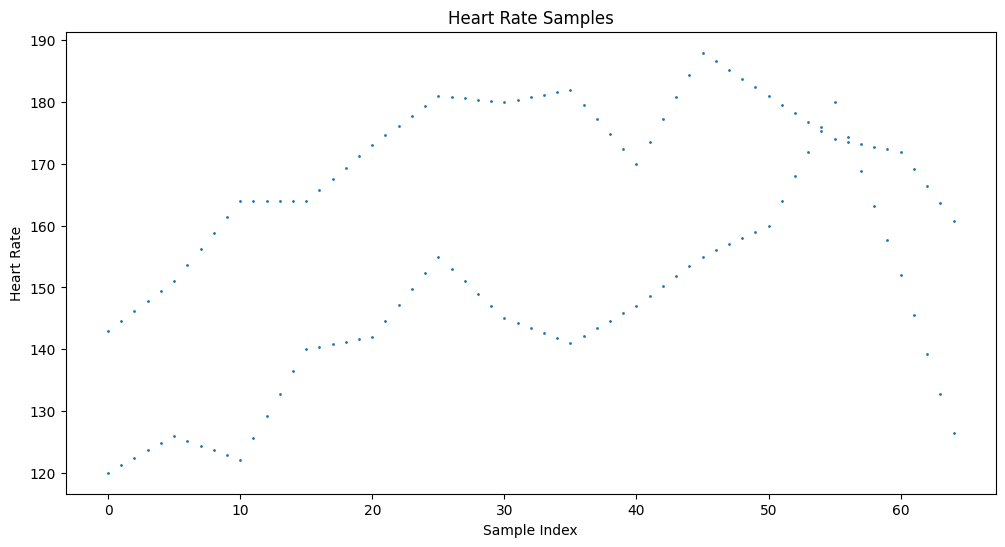

In [3]:
# Plot heart rate over sample index
plt.figure(figsize=(12, 6))
plt.scatter(df['sample_index'], df['heart_rate'], s=1)
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Samples')
plt.show()

## Stationarity Check <a id='stationarity-check'></a>

Time series models like ARIMA require the data to be stationary. We'll perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [4]:
# Perform ADF test
adf_result = adfuller(df['heart_rate'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.3378296214535883
p-value: 0.16005719394126788


In [5]:
# Determine differencing order 'd'
d = 0
if adf_result[1] > 0.05:
    d = 1
    differenced_series = df['heart_rate'].diff().dropna()
    adf_result_diff = adfuller(differenced_series)
    print('After 1st differencing - p-value:', adf_result_diff[1])
    if adf_result_diff[1] > 0.05:
        d = 2
        differenced_series = differenced_series.diff().dropna()
        adf_result_diff = adfuller(differenced_series)
        print('After 2nd differencing - p-value:', adf_result_diff[1])
else:
    differenced_series = df['heart_rate']

print(f'Selected differencing order d = {d}')

After 1st differencing - p-value: 6.499693453221542e-05
Selected differencing order d = 1


## Train-Test Split <a id='train-test-split'></a>

We split the data into training and testing sets (80% training, 20% testing).

In [6]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df['heart_rate'].iloc[:train_size]
test_data = df['heart_rate'].iloc[train_size:]

print(f'Training data size: {len(train_data)}')
print(f'Testing data size: {len(test_data)}')

Training data size: 104
Testing data size: 26


## Model Training and Validation <a id='model-training'></a>

### ARIMA Model <a id='arima-model'></a>

We perform a grid search to find the best hyperparameters for the ARIMA model using Mean Squared Error (MSE) as the evaluation metric.

In [7]:
# Hyperparameter ranges
p_values = range(0, 15)
d_values = [d]
q_values = range(0, 15)

# Further split training data for validation
validation_size = int(len(train_data) * 0.2)
train_data_small = train_data.iloc[:-validation_size]
validation_data = train_data.iloc[-validation_size:]

# Function to evaluate ARIMA model


def evaluate_arima_model(order):
    try:
        model = ARIMA(train_data_small, order=order)
        model_fit = model.fit()
        # Forecast
        forecast = model_fit.forecast(steps=len(validation_data))
        # Calculate median predictions
        predicted_medians = [np.median(forecast[i:i+5])
                             for i in range(len(forecast)-4)]
        actual_medians = [np.median(validation_data.iloc[i:i+5].values)
                          for i in range(len(validation_data)-4)]
        errors = [(pred - actual)**2 for pred,
                  actual in zip(predicted_medians, actual_medians)]
        mse = np.mean(errors)
        return mse
    except:
        return float("inf")


# Grid search
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse = evaluate_arima_model(order)
            if mse < best_score:
                best_score, best_cfg = mse, order
print(f'\nBest ARIMA{best_cfg} MSE={best_score:.4f}')


Best ARIMA(7, 1, 14) MSE=3.7371


### Rolling Median Model <a id='rolling-median-model'></a>

As a baseline, we implement a simple rolling median model, which uses the median of the previous five heart rate values to predict the median of the next five values.

In [8]:
# Combine training and testing data
full_data = pd.concat([train_data, test_data]).reset_index(drop=True)

## Model Evaluation <a id='model-evaluation'></a>

We evaluate both models using Mean Squared Error (MSE) and Mean Absolute Error (MAE). MSE penalizes larger errors more than smaller ones, making it sensitive to outliers. MAE provides a straightforward interpretation of the average error magnitude.

### ARIMA Model Evaluation

In [9]:
# Train final ARIMA model
model = ARIMA(train_data, order=best_cfg)
model_fit = model.fit()

# Forecast for the test set
forecast = model_fit.forecast(steps=len(test_data))

# Calculate median predictions and actual medians
predicted_medians_arima = [np.median(forecast[i:i+5])
                           for i in range(len(forecast)-4)]
actual_medians_arima = [np.median(test_data.iloc[i:i+5].values)
                        for i in range(len(test_data)-4)]
errors_arima = [(pred - actual)**2 for pred,
                actual in zip(predicted_medians_arima, actual_medians_arima)]
time_points_arima = [train_size +
                     i for i in range(len(predicted_medians_arima))]

# Error metrics for ARIMA model
mse_arima = np.mean(errors_arima)
mae_arima = np.mean([abs(pred - actual) for pred,
                    actual in zip(predicted_medians_arima, actual_medians_arima)])

print(f'ARIMA Model MSE: {mse_arima:.4f}')
print(f'ARIMA Model MAE: {mae_arima:.4f}')

ARIMA Model MSE: 155.9116
ARIMA Model MAE: 11.6605


### Rolling Median Model Evaluation

In [10]:
# Rolling median predictions
predicted_medians_median = []
actual_medians_median = []
errors_median = []
time_points_median = []

for i in range(train_size, len(full_data) - 5):
    last_5 = full_data.iloc[i-5:i]
    predicted_median = np.median(last_5)
    next_5 = full_data.iloc[i:i+5]
    actual_median = np.median(next_5)
    error = (predicted_median - actual_median) ** 2

    predicted_medians_median.append(predicted_median)
    actual_medians_median.append(actual_median)
    errors_median.append(error)
    time_points_median.append(i)

# Error metrics for Rolling Median model
mse_median = np.mean(errors_median)
mae_median = np.mean([abs(pred - actual) for pred,
                     actual in zip(predicted_medians_median, actual_medians_median)])

print(f'Rolling Median Model MSE: {mse_median:.4f}')
print(f'Rolling Median Model MAE: {mae_median:.4f}')

Rolling Median Model MSE: 42.3390
Rolling Median Model MAE: 5.7714


## Residual Analysis <a id='residual-analysis'></a>

Analyzing the residuals of the ARIMA model helps validate its assumptions and check for patterns that might indicate model inadequacies.

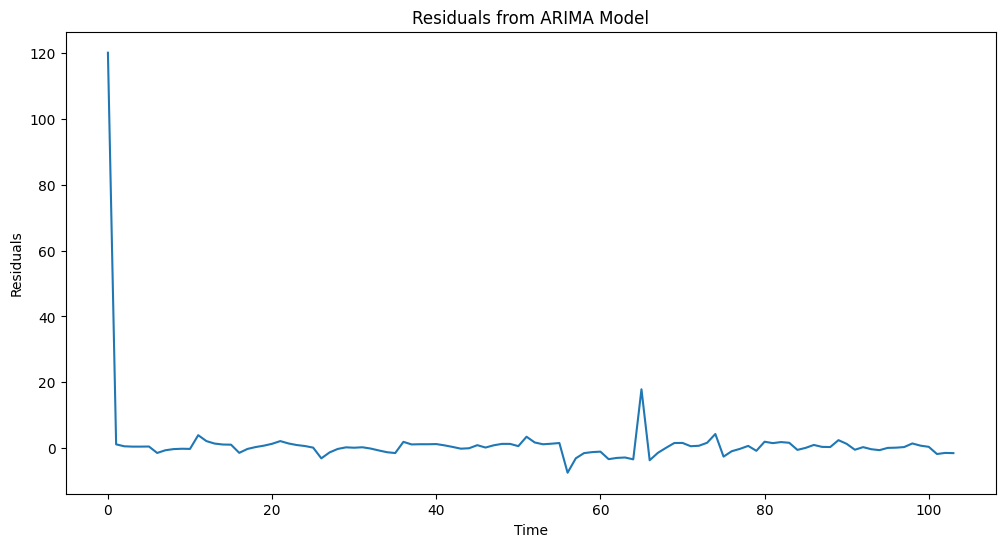

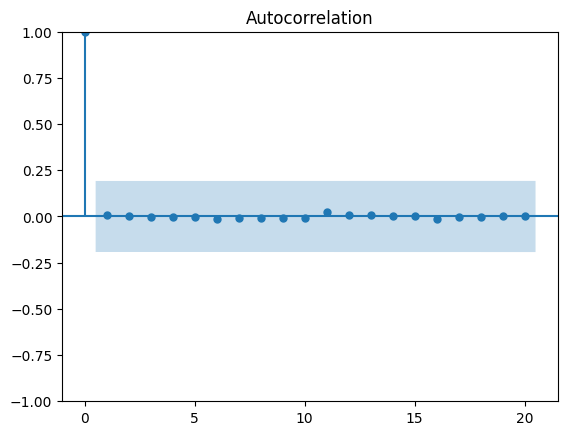

Normality test p-value: 5.988682560646935e-48
Residuals may not be normally distributed.


In [11]:
# Residuals from ARIMA model
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Autocorrelation of residuals
plot_acf(residuals, lags=20)
plt.show()

# Normality test
stat, p = normaltest(residuals)
print('Normality test p-value:', p)
if p > 0.05:
    print('Residuals seem to be normally distributed.')
else:
    print('Residuals may not be normally distributed.')

## Conclusion <a id='conclusion'></a>

### Error Metric Justification

- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values. It penalizes larger errors more severely, making it sensitive to outliers. It's suitable when large errors are particularly undesirable.
- **Mean Absolute Error (MAE)**: Measures the average absolute difference between predicted and actual values. It provides a straightforward interpretation of the average error magnitude.

Using both MSE and MAE provides a comprehensive evaluation of the models' predictive performance.

### Model Comparison Visualization

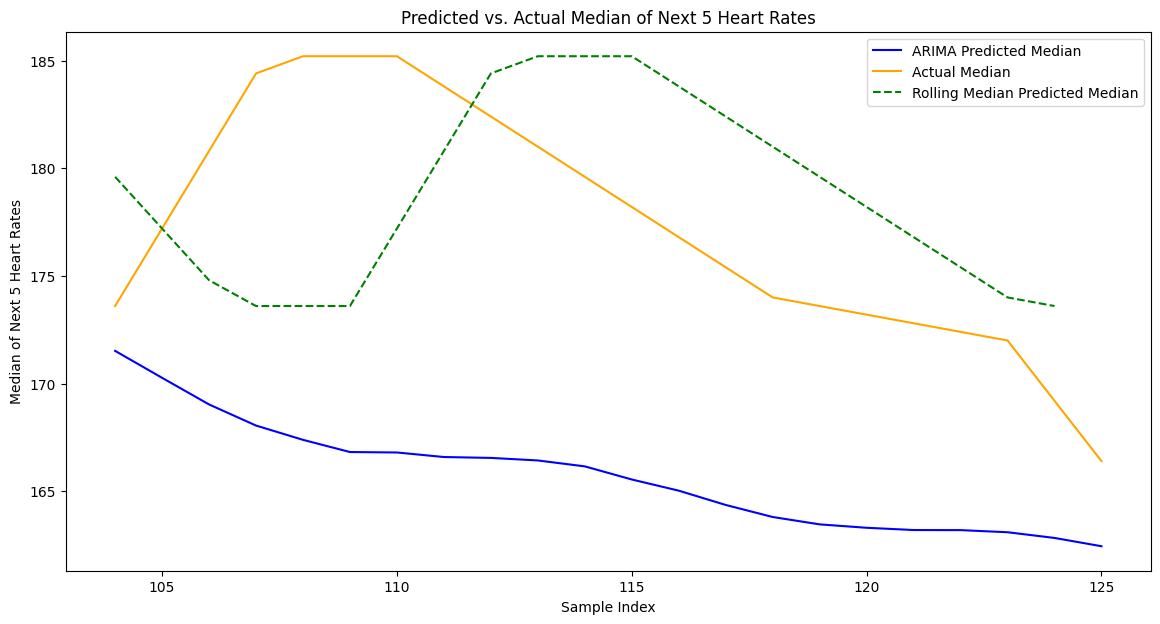

In [12]:
# Plot the predicted and actual medians
plt.figure(figsize=(14, 7))

# Plot ARIMA predictions
plt.plot(time_points_arima, predicted_medians_arima,
         label='ARIMA Predicted Median', color='blue')
plt.plot(time_points_arima, actual_medians_arima,
         label='Actual Median', color='orange')

# Plot Rolling Median predictions
plt.plot(time_points_median, predicted_medians_median,
         label='Rolling Median Predicted Median', color='green', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Median of Next 5 Heart Rates')
plt.title('Predicted vs. Actual Median of Next 5 Heart Rates')
plt.legend()
plt.show()